### ARIMA MODELLING

In [1]:
library("ggplot2")
library("readxl")
library("forecast")
library("tseries")
library("urca")

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [2]:
covid<-data.frame(read_excel("../input/ccovid.xlsx"))

In [3]:
options(repr.plot.width=15, repr.plot.height=8)

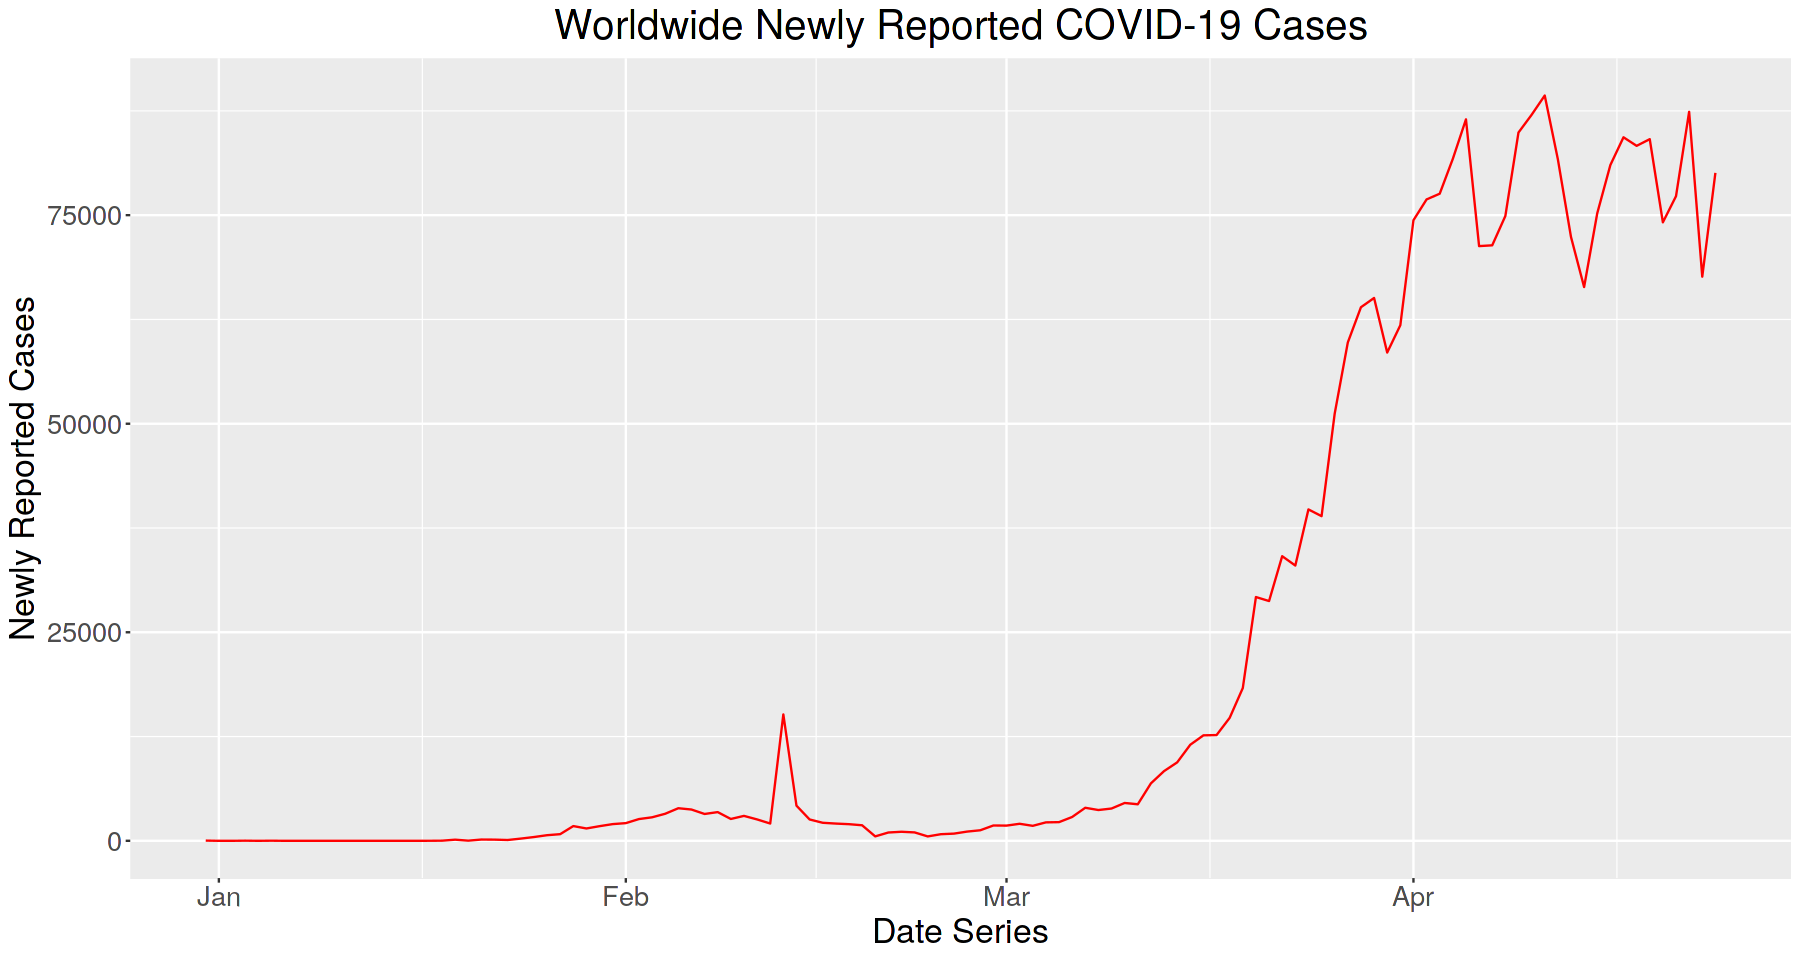

In [4]:
total_cases_by_date<-aggregate(covid$cases,by=list(covid$dateRep),FUN=sum)
covid_report_plot<-ggplot(total_cases_by_date,aes(Group.1,x))+geom_line(color="red")
covid_report_plot+ggtitle("Worldwide Newly Reported COVID-19 Cases")+labs(y="Newly Reported Cases", x = "Date Series")+theme(plot.title = element_text(hjust = 0.5))+theme(text = element_text(size=20))  #time-series

In [5]:
total_cases_by_date<-tail(total_cases_by_date,-21)
covidplots<-total_cases_by_date$x

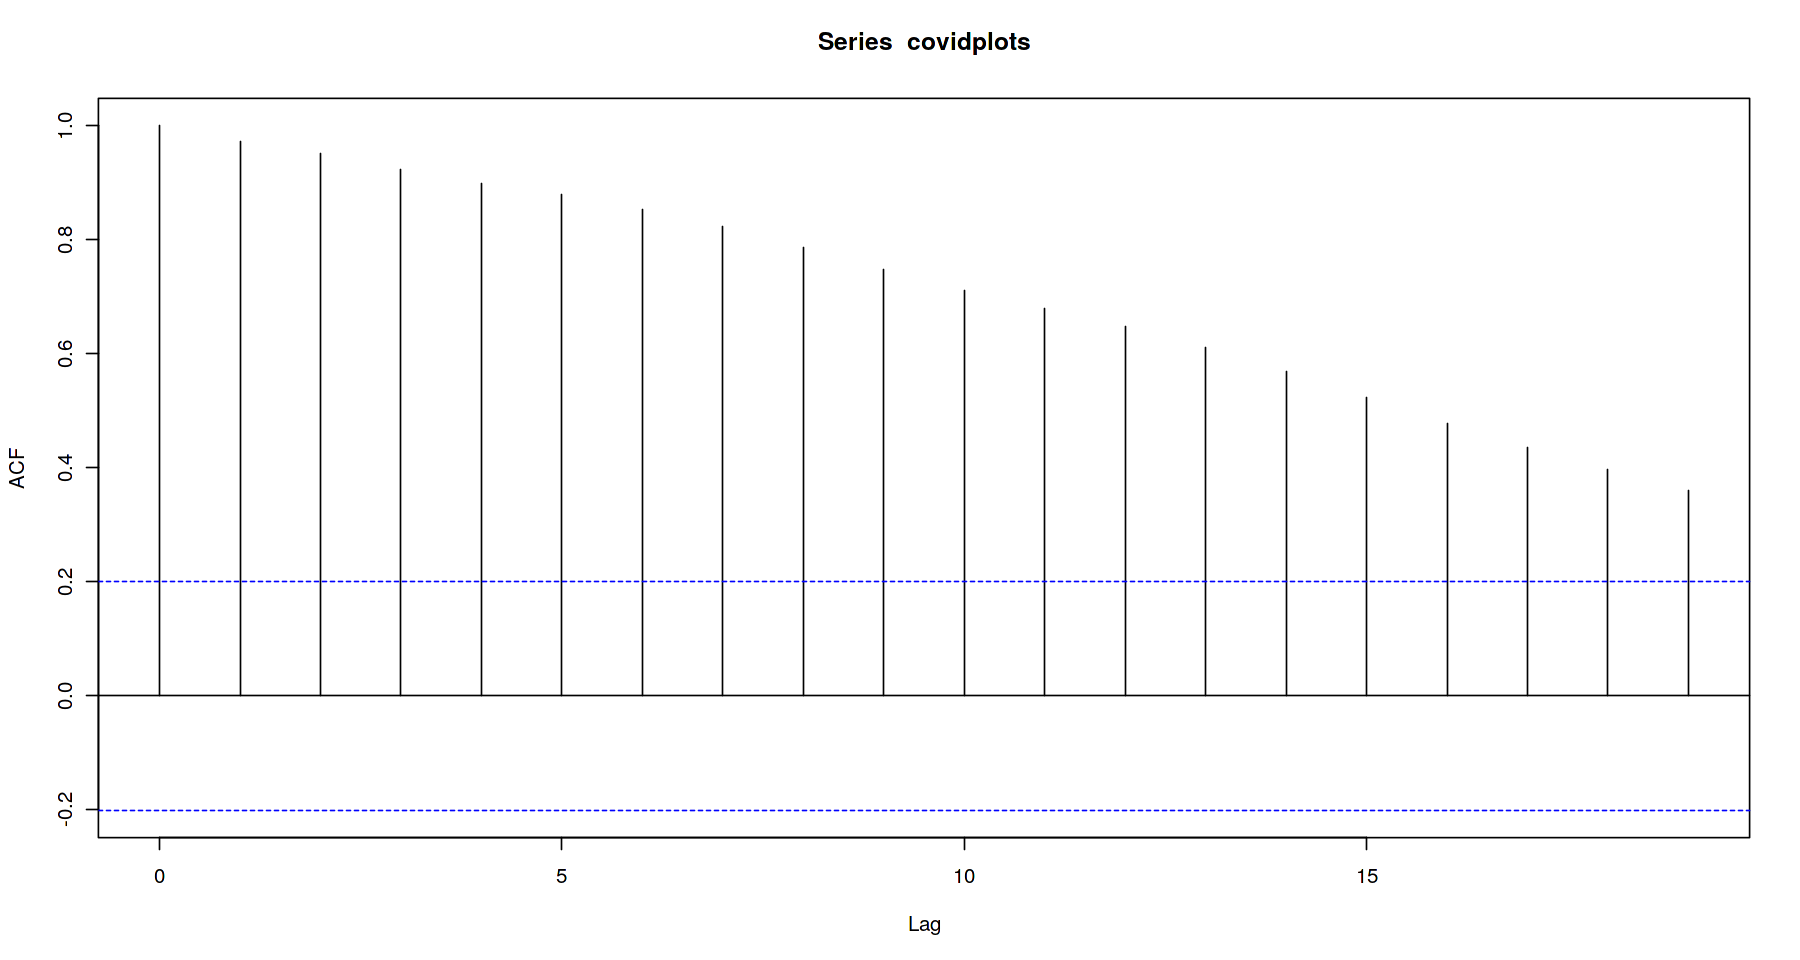

In [6]:
acf(covidplots)

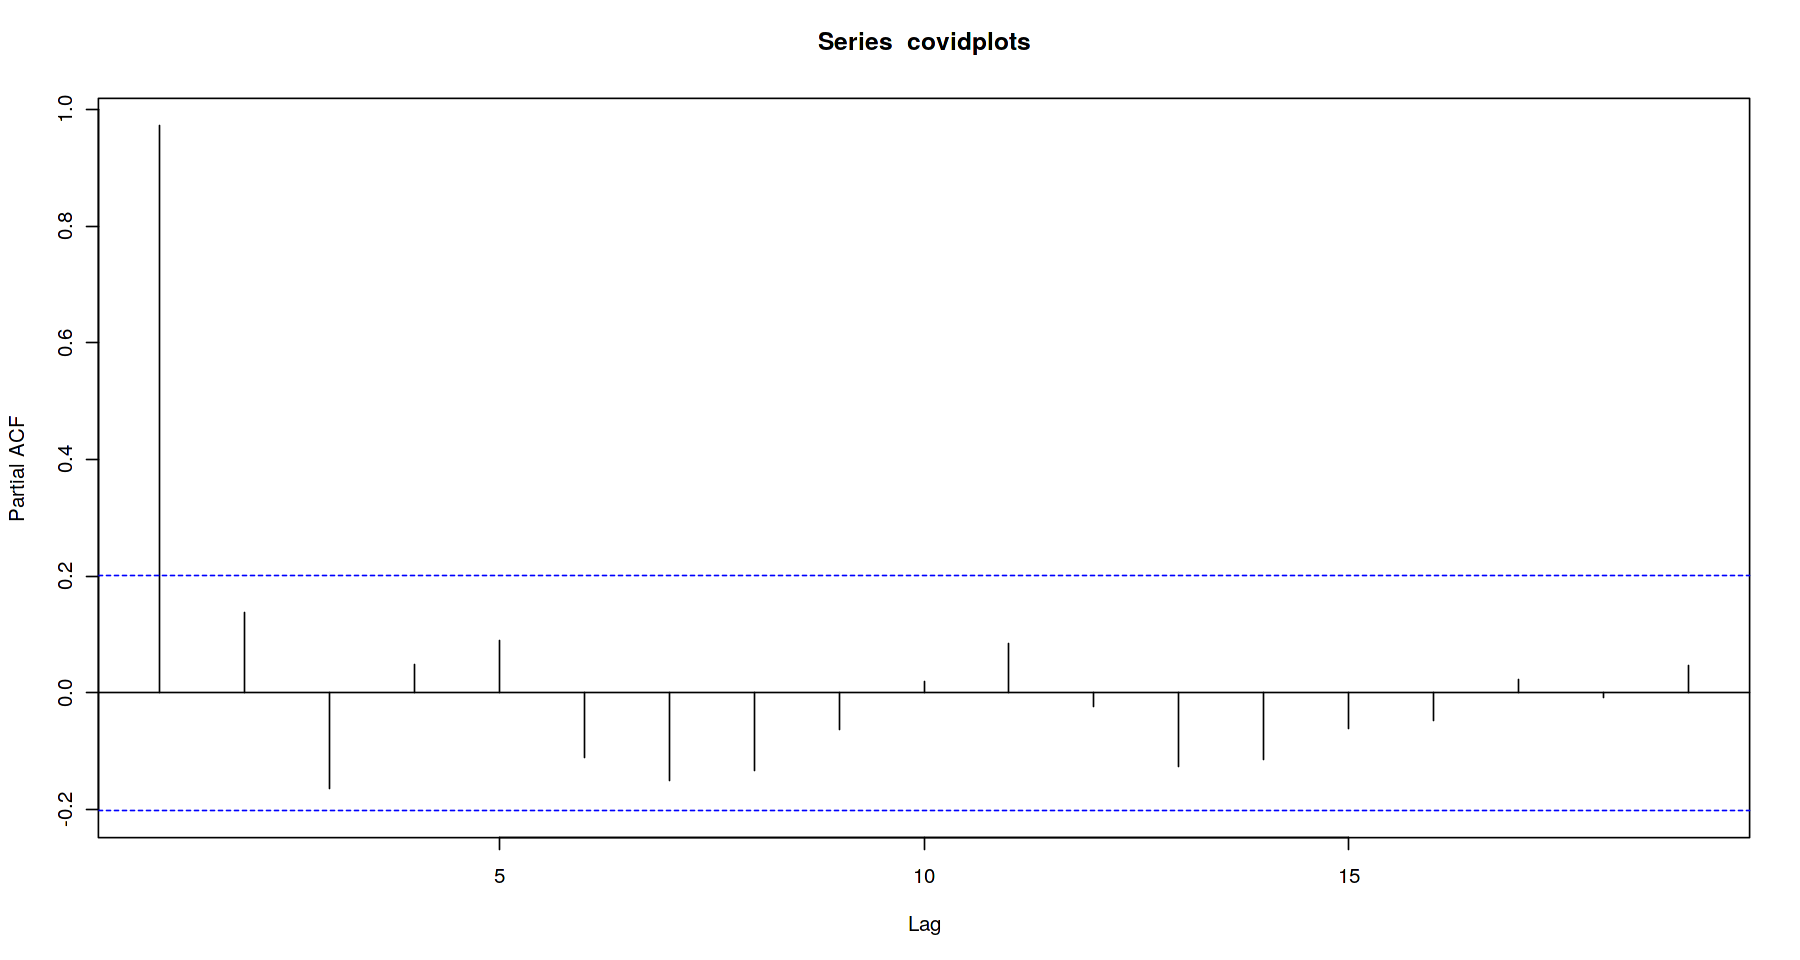

In [7]:
pacf(covidplots)

In [8]:
train<-head(covidplots,round(length(covidplots)*0.75))
d<-length(covidplots)-length(train)
test<-tail(covidplots,d)

In [9]:
param<-auto.arima(train)
param

Series: train 
ARIMA(1,2,1) 

Coefficients:
          ar1      ma1
      -0.2015  -0.8780
s.e.   0.1251   0.0595

sigma^2 estimated as 10828510:  log likelihood=-656.63
AIC=1319.27   AICc=1319.63   BIC=1325.97

In [10]:
plotfit<-arima(train,c(1,2,1))
plotfit


Call:
arima(x = train, order = c(1, 2, 1))

Coefficients:
          ar1      ma1
      -0.2015  -0.8780
s.e.   0.1251   0.0595

sigma^2 estimated as 10514641:  log likelihood = -656.63,  aic = 1319.27

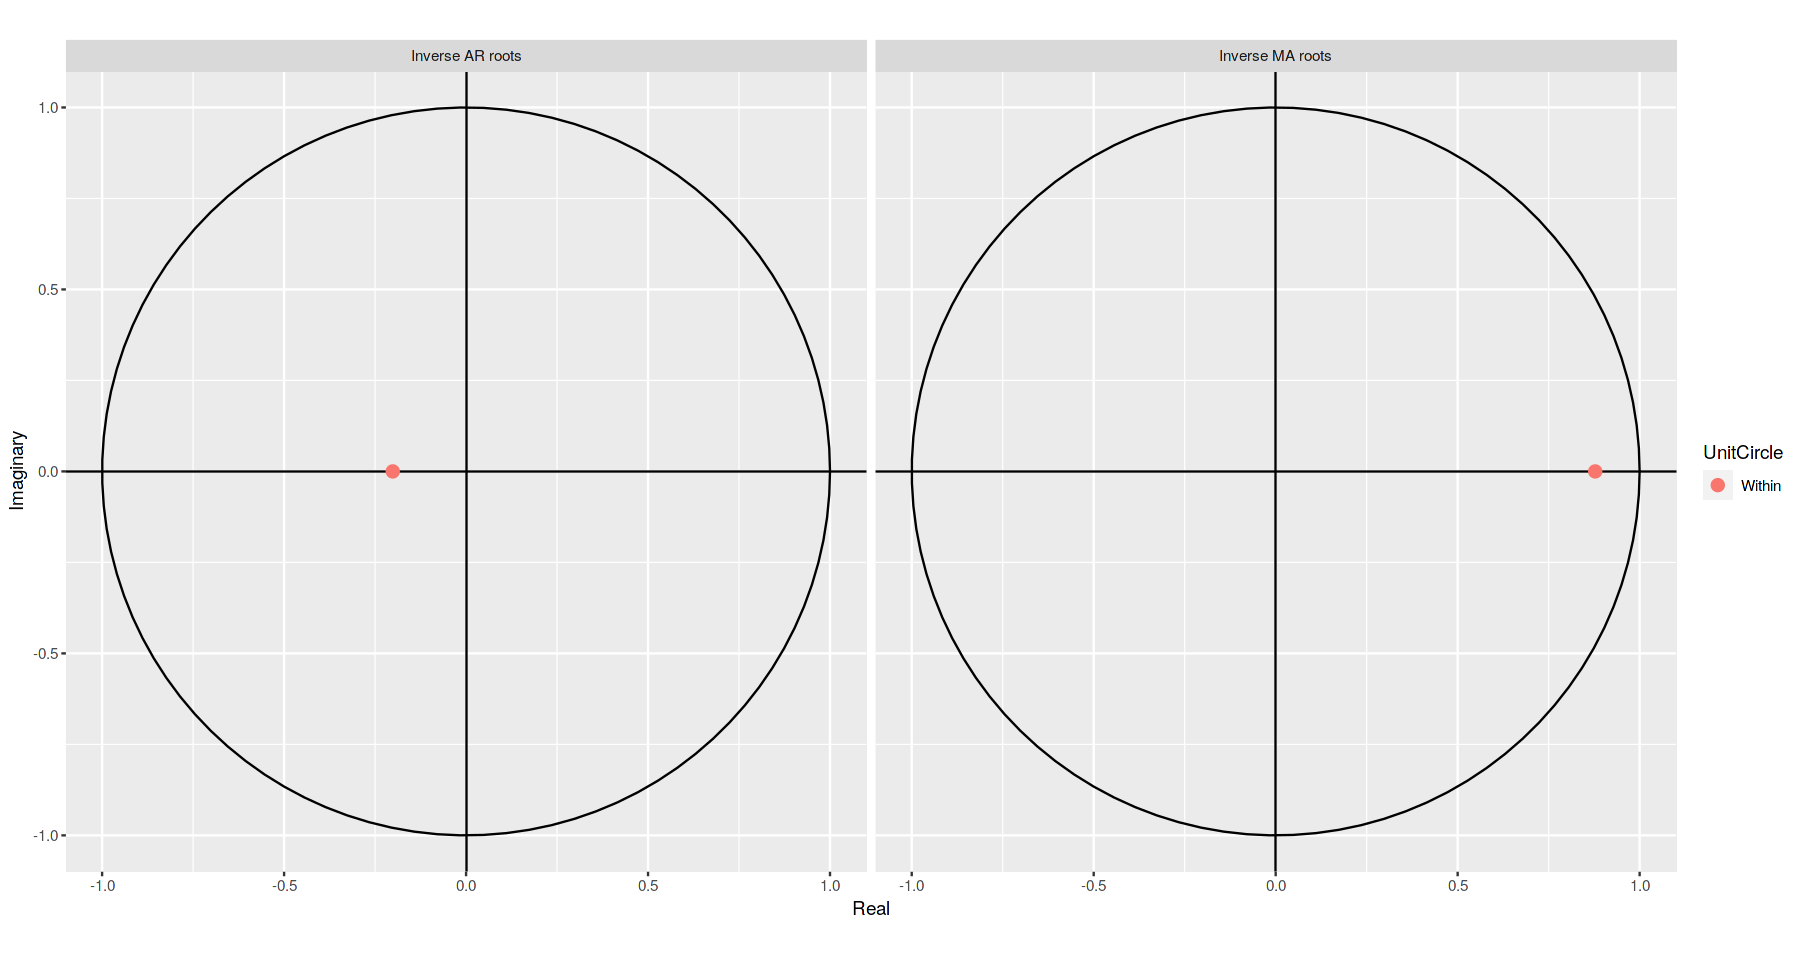

In [11]:
autoplot(plotfit)


	Ljung-Box test

data:  Residuals from ARIMA(1,2,1)
Q* = 9.9462, df = 8, p-value = 0.2688

Model df: 2.   Total lags used: 10



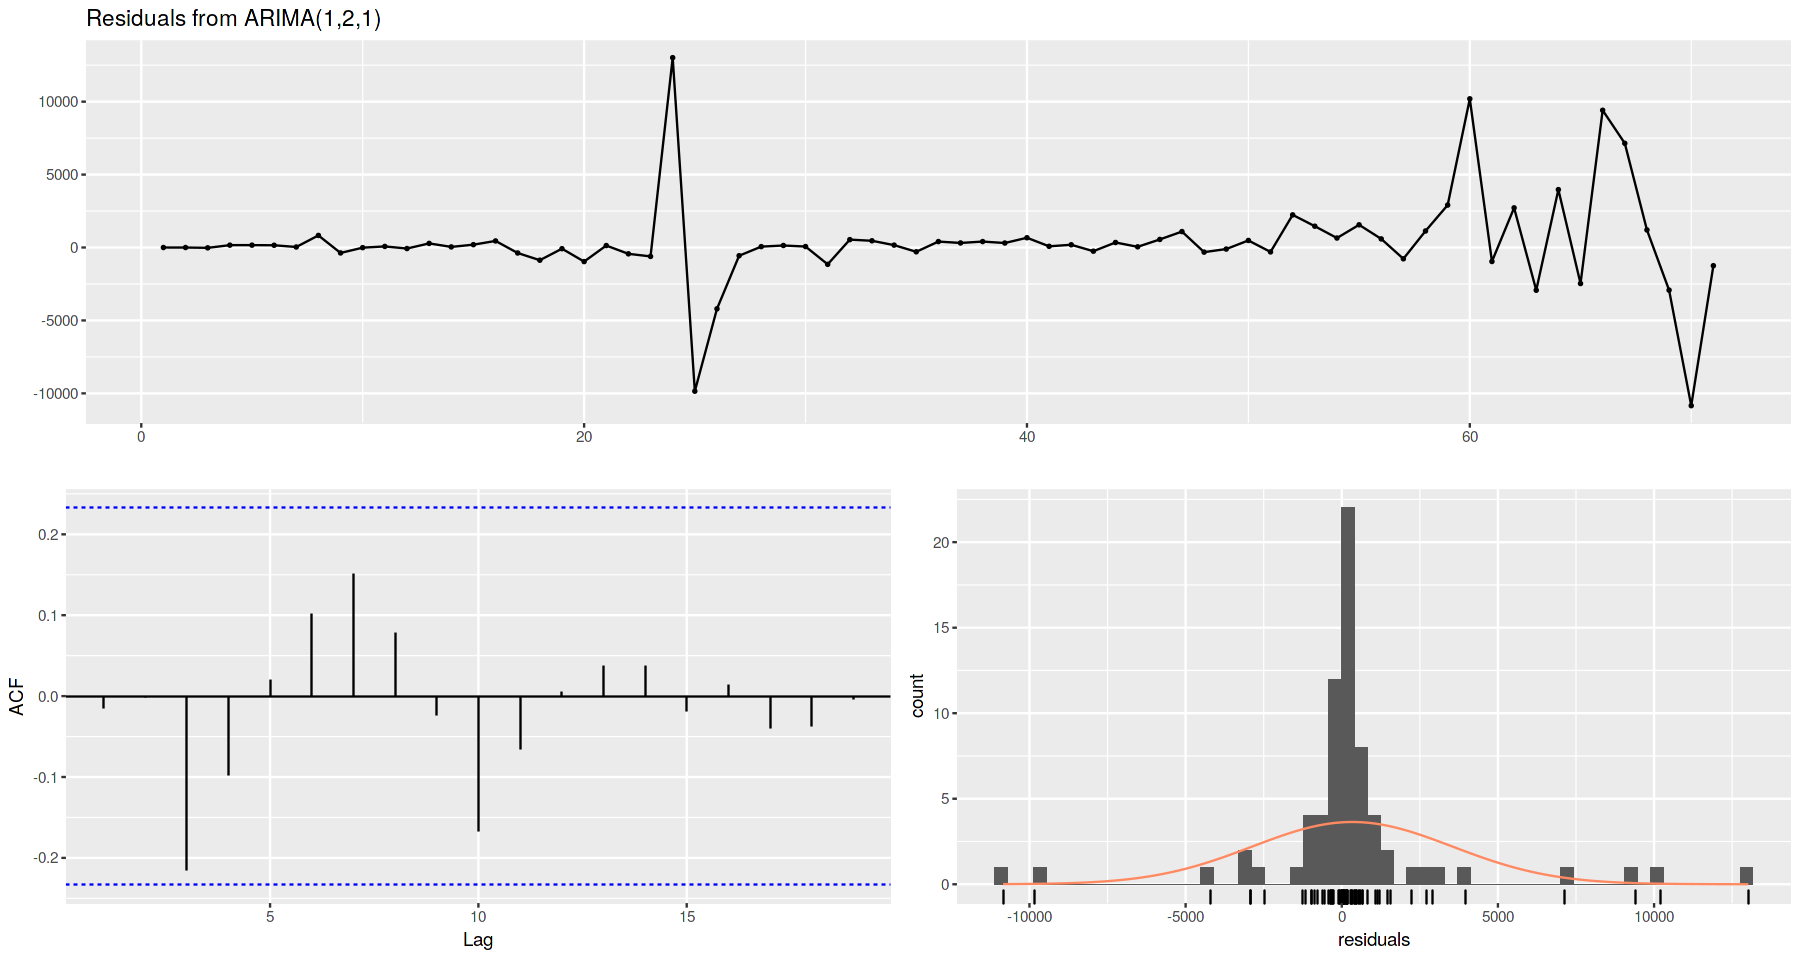

In [12]:
checkresiduals(plotfit)

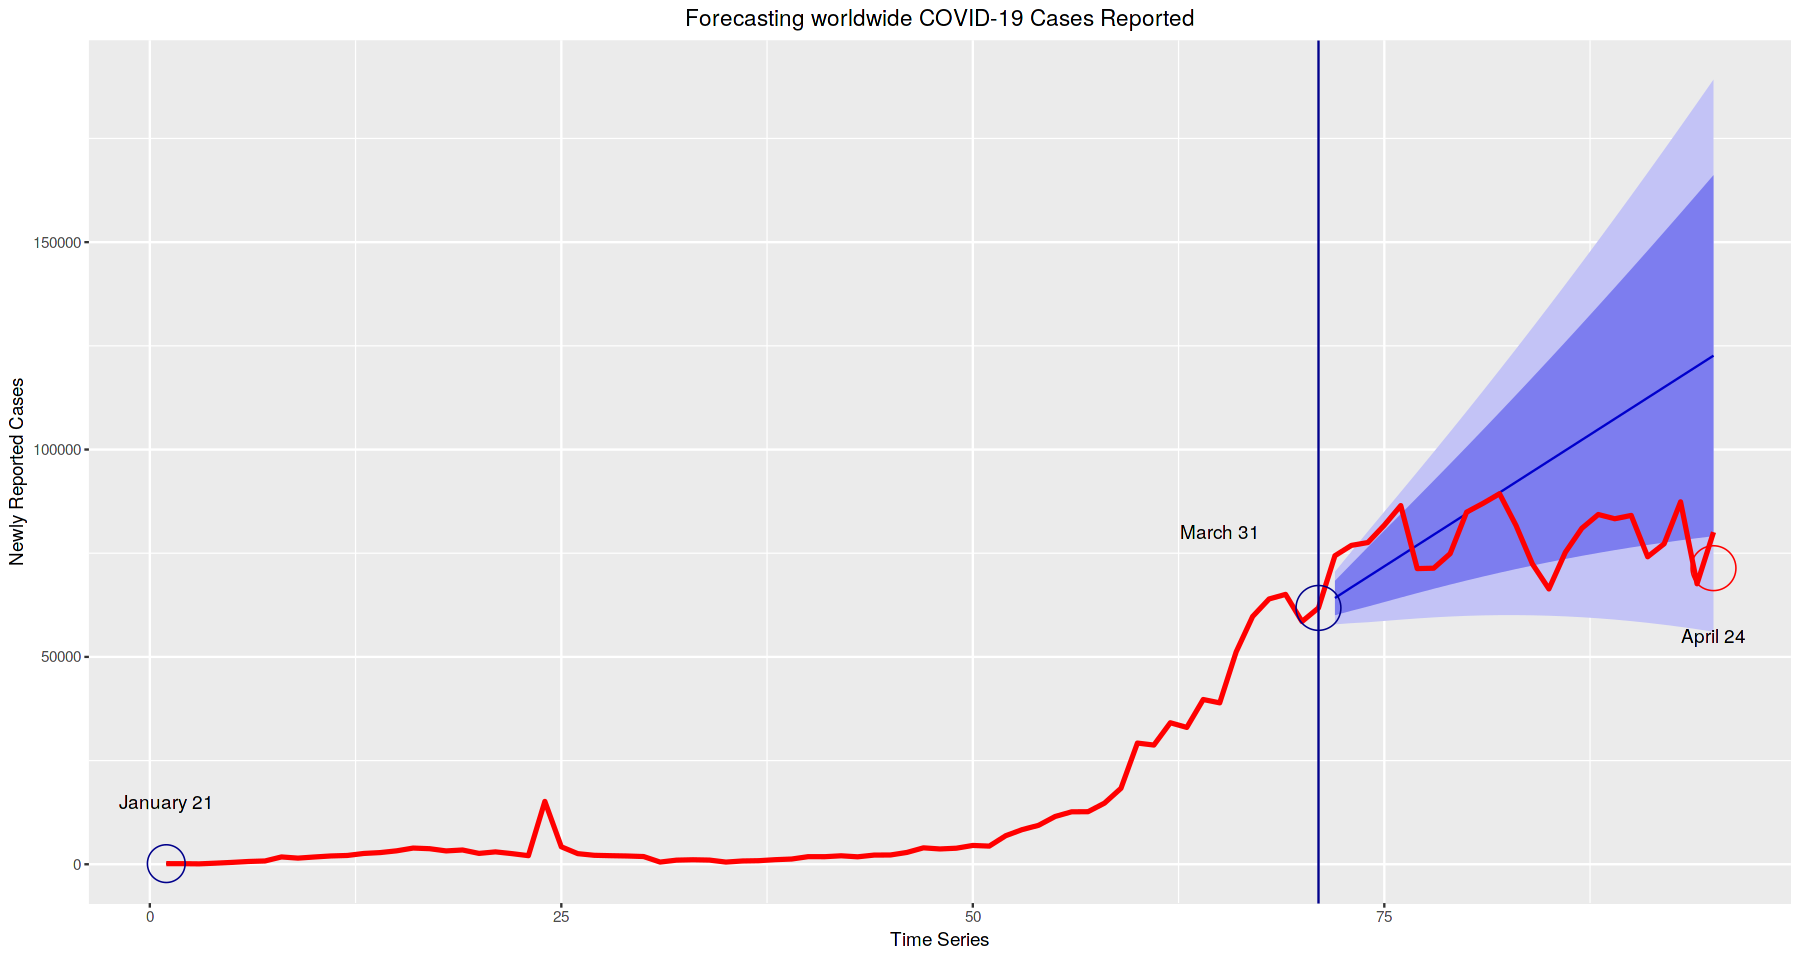

In [13]:
p<-ts(total_cases_by_date$x)
autoplot(forecast(plotfit,h=24))+autolayer(p,size=1.1,color="red")+
  ggtitle("Forecasting worldwide COVID-19 Cases Reported")+labs(y="Newly Reported Cases", x = "Time Series")+
  theme(plot.title = element_text(hjust = 0.5))+geom_vline(xintercept = 71,color="darkblue")+
  annotate(geom="text",x=1,y=15000,label="January 21")+
  annotate(geom="point", x=1,y=153,size=10,shape=21,fill="transparent",color="darkblue")+
  annotate(geom="text",x=65,y=80000,label="March 31")+
  annotate(geom="point", x=71,y=61808,size=12,shape=21,fill="transparent",color="darkblue")+
  annotate(geom="text",x=95,y=55000,label="April 24")+
  annotate(geom="point", x=95,y=71392,size=12,shape=21,fill="transparent",color="red")

In [14]:
f<-forecast(plotfit)

forecastvalues<-data.frame(forecast(plotfit,h=24))
fvalues<-forecastvalues$Point.Forecast
fvalues<-ceiling(fvalues)

accuracy(fvalues,test)

,ME,RMSE,MAE,MPE,MAPE
Test set,-14644.58,23562.56,18890.75,-19.32991,24.66839


### End

### Linear Regression Modelling

In [15]:
train<-head(covidplots,round(length(covidplots)*0.75))
d<-length(covidplots)-length(train)
test<-tail(covidplots,d)

In [16]:
difference<-function(data,interval){
updata<-vector()
for(i in interval:length(data)-1){
    updata[i]<-(data[i+interval]-data[i])
}
return(updata)
}

### Lag-1 Differencing

In [17]:
transformed <- difference(train, 1)

In [18]:
p<-ts(transformed)
fit<-tslm(p~trend)
fit


Call:
tslm(formula = p ~ trend)

Coefficients:
(Intercept)        trend  
    -886.47        49.78  



	Breusch-Godfrey test for serial correlation of order up to 10

data:  Residuals from Linear regression model
LM test = 15.11, df = 10, p-value = 0.1281


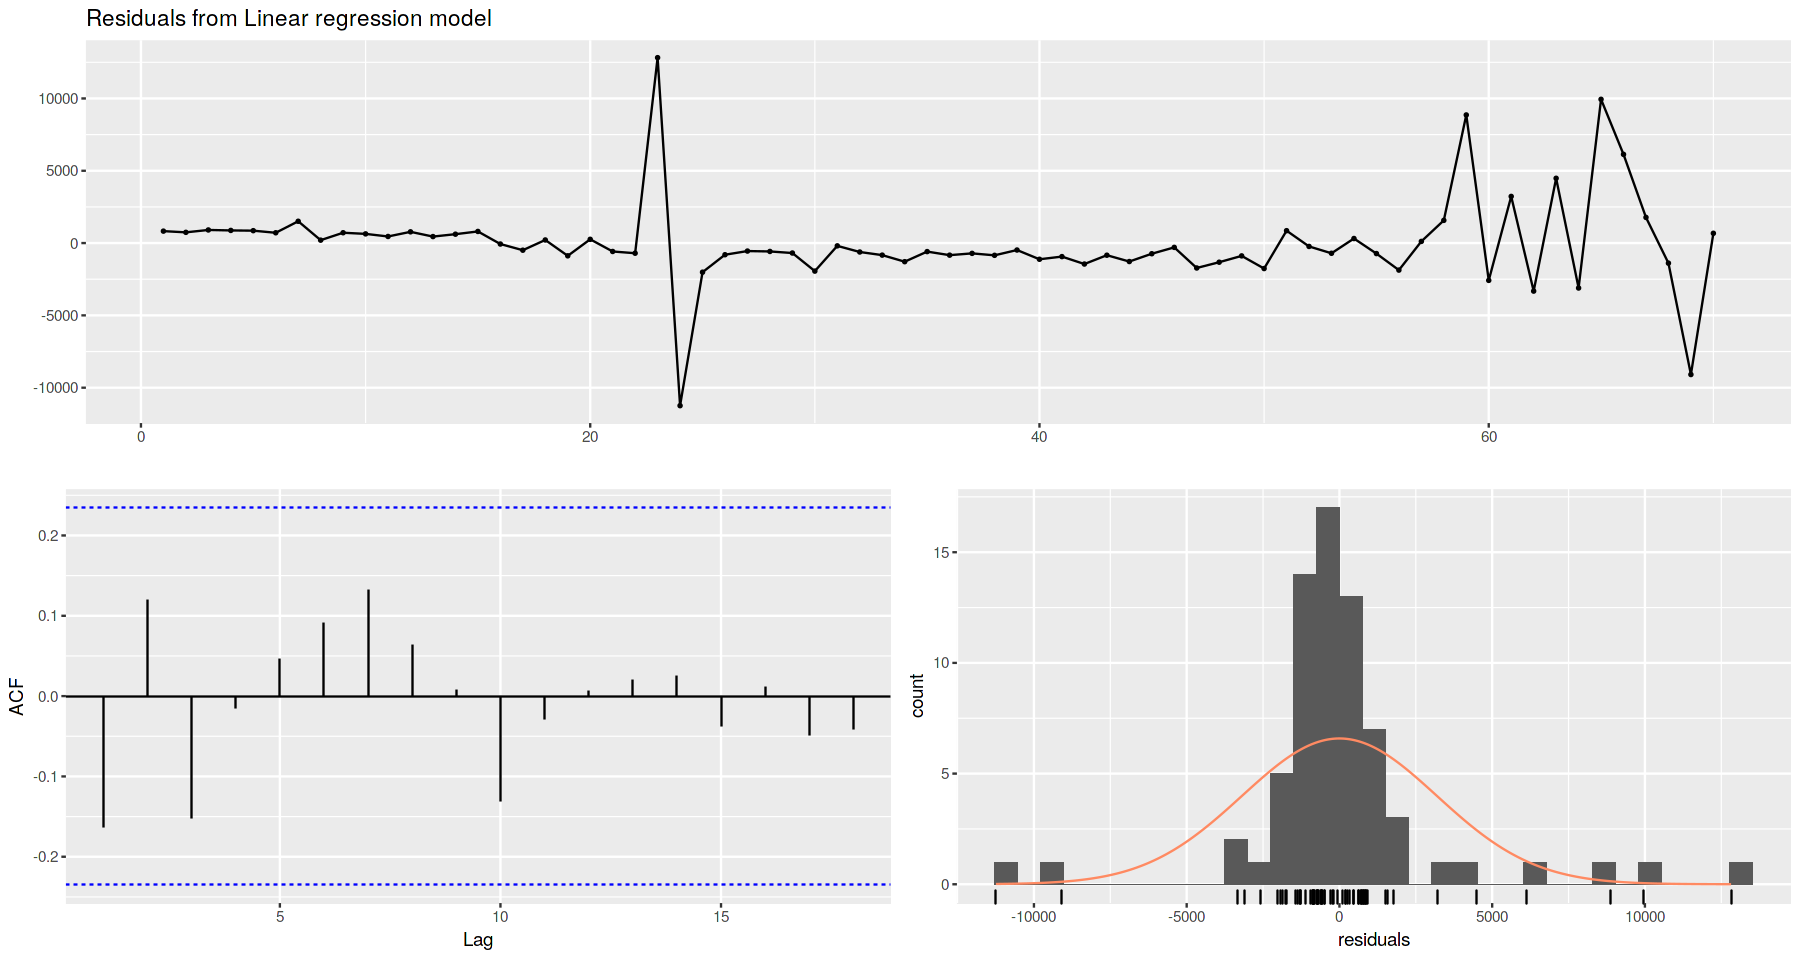

In [19]:
checkresiduals(fit)

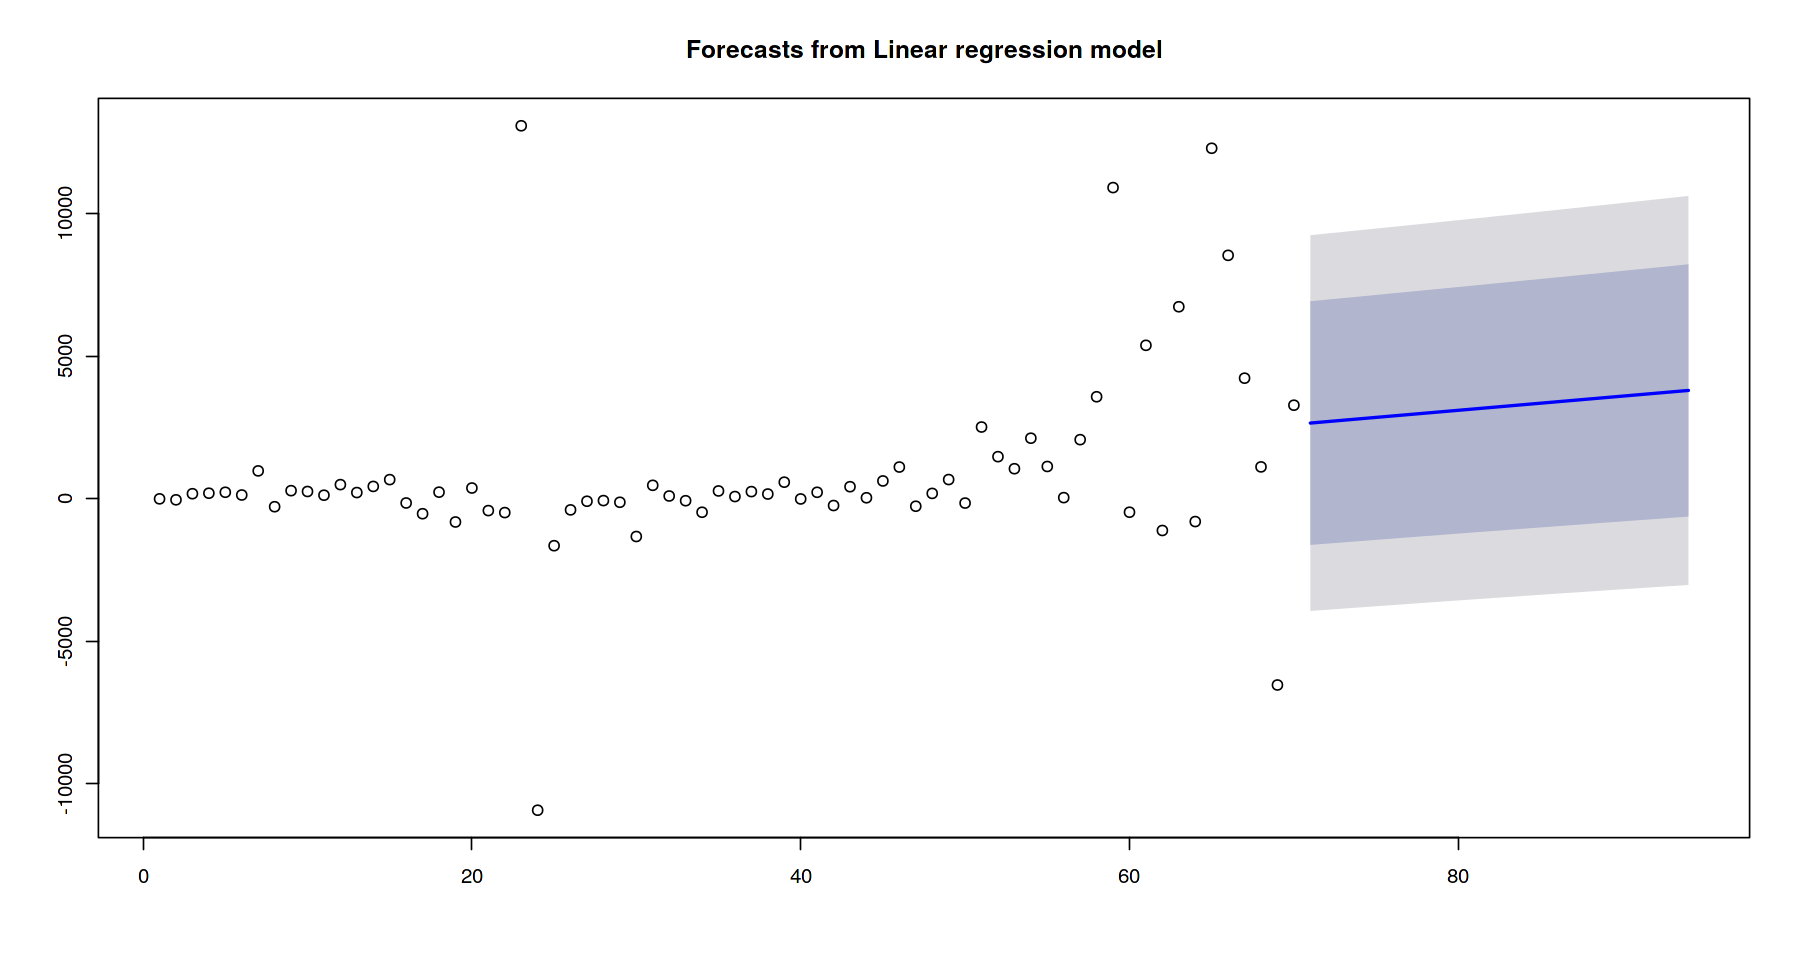

In [20]:
plot(forecast(fit,h=24),type="p")

In [21]:
forecastvalues<-data.frame(forecast(fit,h=24))

In [22]:
fvalues<-forecastvalues$Point.Forecast
fvalues<-ceiling(fvalues)

lo95<-forecastvalues$Lo.95
lo95<-ceiling(lo95)

hi95<-forecastvalues$Hi.95
hi95<-ceiling(hi95)

In [23]:
invertdifference<-function(orig,diff,interval){
  upd<-vector()
  for(i in interval:length(orig)){
    upd[i]<-orig[i+interval]-diff[i]
  }
  upd[i]=upd[i-1]+diff[i-1]
  return(upd)
}

### Inverting Lag-1 Differencing

In [24]:
fvalues<-invertdifference(test,fvalues,1)
lo95<-invertdifference(test,lo95,1)
hi95<-invertdifference(test,hi95,1)

In [25]:
ytest<-append(train,test)
ypred<-append(train,fvalues)
ylow<-append(train,lo95)
yhigh<-append(train,hi95)

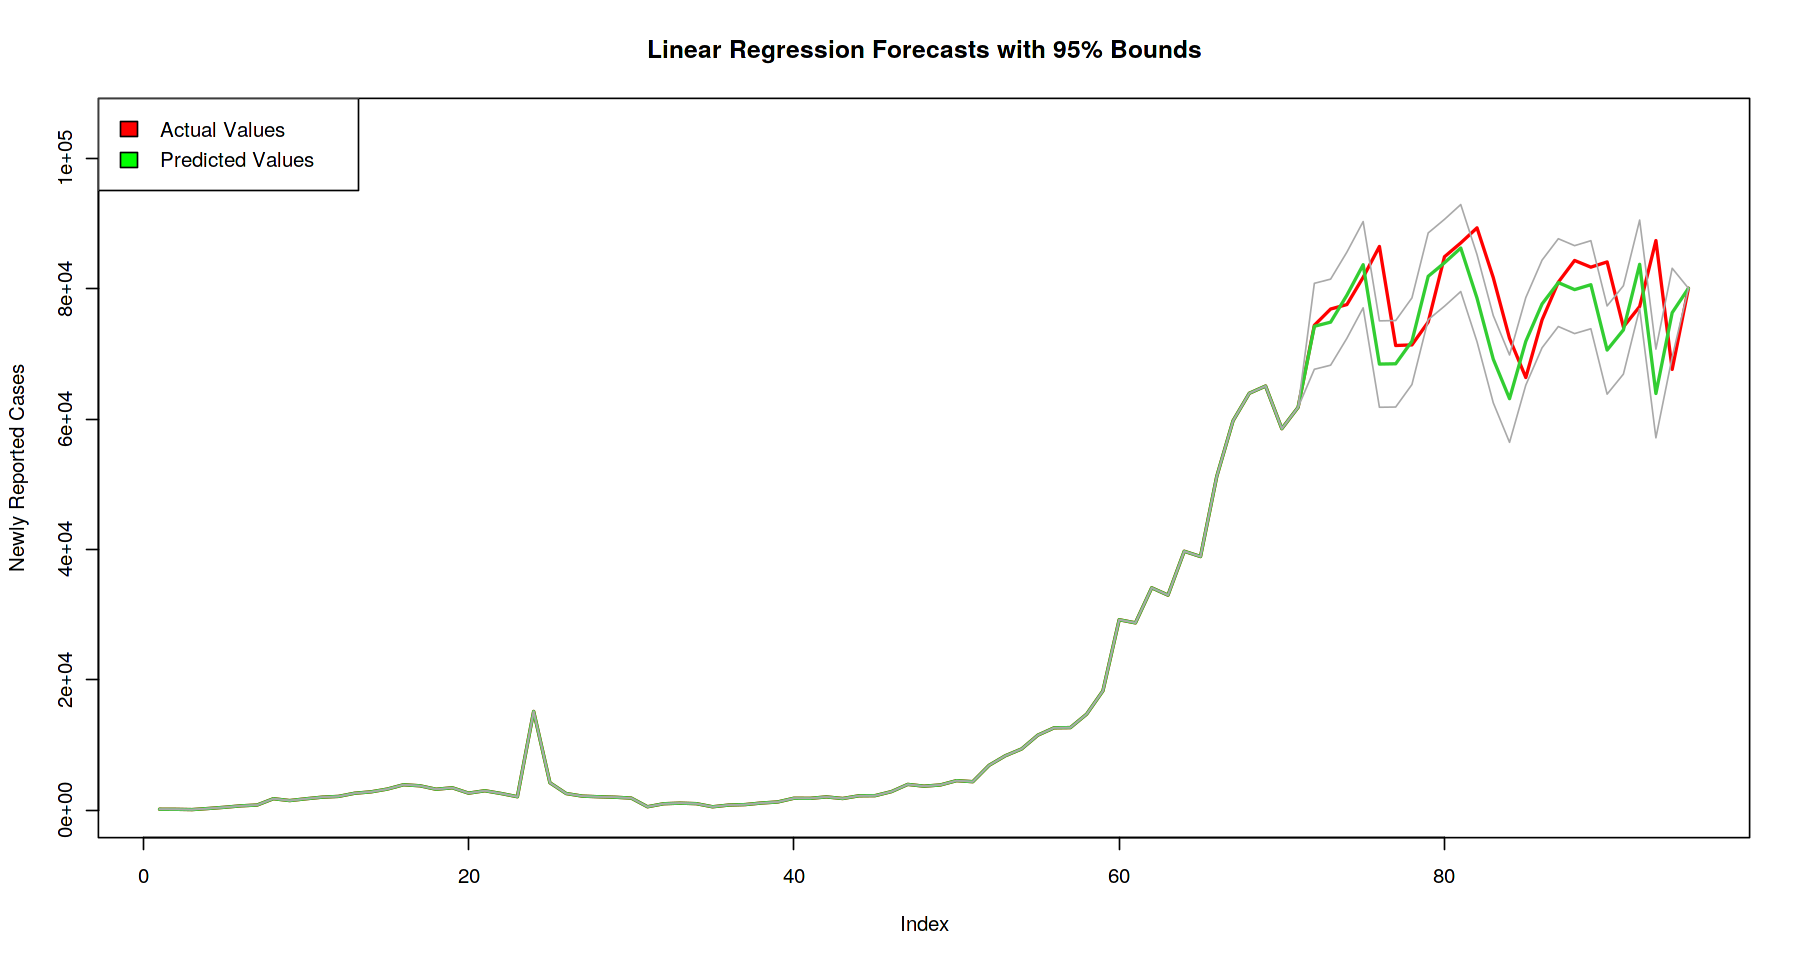

In [31]:
plot(ytest,col="red",type="l",ylim=c(0,105000),main="Linear Regression Forecasts with 95% Bounds",ylab="Newly Reported Cases",lwd=2)
lines(ypred,col="lime green",lwd=2)
lines(ylow,col="dark grey")
lines(yhigh,col="dark grey")
legend("topleft",
c("Actual Values","Predicted Values"),
fill=c("red","green"))

In [ ]:
accuracy(fvalues,test)

### End